In [2]:
from nbimport_helper import setup_notebook_imports, nbimport

setup_notebook_imports(r'D:\computer vision\drive-download-20251028T233500Z-1-001')

ALD_lane = nbimport('ALD_Updated_Lane_search')
main = ALD_lane.main

camera_cal = nbimport('ALD_CAMERA_CAL')
get_new_camera_matrix = camera_cal.get_new_camera_matrix

ALD_COLORANDGRAD = nbimport('ALD_COLORANDGRAD')
Color_and_Grad = ALD_COLORANDGRAD.Color_and_Grad

ALD_bev = nbimport('ALD_BEV')
Bev = ALD_bev.Bev

ALD_Histogram = nbimport('ALD_HISTORGRAM')
fit_polynomial = ALD_Histogram.fit_polynomial

Notebook import path added: D:\computer vision\drive-download-20251028T233500Z-1-001


In [3]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import nbimporter
# from ALD_Updated_Lane_search import main
# from ALD_CAMERA_CAL import get_new_camera_matrix
# from ALD_COLORANDGRAD import Color_and_Grad
# from ALD_BEV import Bev
# from ALD_HISTORGRAM import fit_polynomial


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2456\3392027963.py:3: SyntaxWarning: invalid escape sequence '\c'
  cap = cv2.VideoCapture("D:\computer vision\drive-download-20251028T233500Z-1-001\challenge (1).mp4") # input video path


1659.9395964909947 1547.2266803076768
1703.9894578775475 1535.302612168897
1721.372336088558 1540.5641872619553
1981.9914586611626 1710.3371587129914
1925.4541047619468 1881.955053629339
1798.0052184099059 1537.9583436356686
1797.4742497388222 1517.2776842480646
1656.2469472221476 1576.4813658261583
1599.1135794970512 1544.373420646045
1605.6695034564398 1609.2824625830087
1582.7383012623532 1563.937648357981
1616.4208565228398 1657.338012893445
1645.4055868005123 1648.0468555832476
1586.7966632148173 1659.1072468972977
1622.0625069159364 1660.0858153927597
1637.633936866039 2213.8582278322374
1596.5653896524457 2288.082649592248
1586.3512396463086 2133.821330586844
1516.442865034299 1798.9306180995104
1505.0790520148746 1673.2190876595348
1509.9896711762788 1779.322385107144
1531.5975631565943 1751.7085041792902
1567.7280137968373 1845.8048669798193
1592.6633330691661 1893.696103765621
1623.076430371382 1746.1994262947178
1695.430925397614 1849.4597508710438
1639.791725861125 1765.677

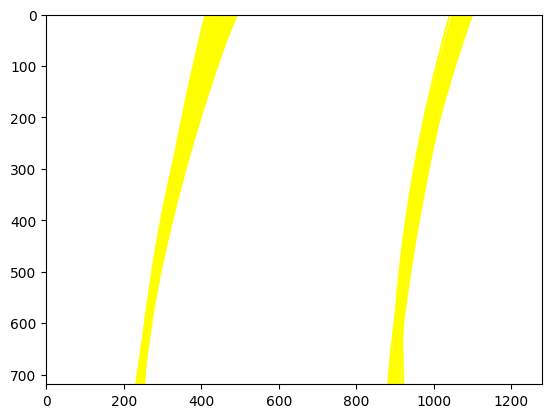

In [4]:


def Main():
    New_camera_matrix, mtx, dist = get_new_camera_matrix() 
    cap = cv2.VideoCapture("D:\computer vision\drive-download-20251028T233500Z-1-001\challenge (1).mp4") # input video path
    
    # ---- Video Writer Setup ----
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # codec (use 'XVID' for .avi)
    fps = int(cap.get(cv2.CAP_PROP_FPS))      # get FPS from input video
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter("output_lane_detection.mp4", fourcc, fps, (width, height))
    left_fit=None
    right_fit=None
    boolval=True
    left_c=None
    right_c=None

    while cap.isOpened():
        check, frame = cap.read()
        if not check:   #not wil change False into True and True into False  
            break
        
        # Step 1: Undistort
        undistorted = cv2.undistort(frame, mtx, dist, None, New_camera_matrix)
        
        # Step 2: COLOR AND GRAD    RGB  HLS HVS
        Combinedimg = Color_and_Grad(undistorted, 250, 220, 250, 220, 140, 200)

        # Step 3: BEV
        BEVIMG = Bev(Combinedimg)

        # Step 4: Normalize (float image 0–1)
        Normalizedimg = BEVIMG / 255.0

        # Step 5: Histogram + Polynomial Fit
        fitimg, left_fit1,right_fit1,boolval2, left_fitm00, right_fitm00= fit_polynomial(Normalizedimg, left_fit, right_fit,boolval)  
        boolval=boolval2
        left_fit=left_fit1
        right_fit=right_fit1
        
        def measure_curvature_pixels():
          
            # Define y-value where we want radius of curvature
            # We'll choose the maximum y-value, corresponding to the bottom of the image
            ploty1= np.linspace(0,height-100, height-99)
            y_eval = np.max(ploty1)
            
            # Calculation of R_curve (radius of curvature)
            left_curverad = ((1 + (2*left_fitm00[0]*y_eval + left_fitm00[1])**2)**1.5) / np.absolute(2*left_fitm00[0])
            right_curverad = ((1 + (2*right_fitm00[0]*y_eval + right_fitm00[1])**2)**1.5) / np.absolute(2*right_fitm00[0])
            
            return left_curverad, right_curverad

        #Step 6: calculate radius of curtvature to control car steering angle
        left_c, right_c = measure_curvature_pixels()
        print(left_c,right_c)


        

        # Convert grayscale → BGR if needed
        if len(fitimg.shape) == 2 or fitimg.shape[2] == 1:
            fitimg_bgr = cv2.cvtColor(fitimg, cv2.COLOR_GRAY2BGR)
        else:
            fitimg_bgr = fitimg

        #Ensure frame is uint8 before writing
        if fitimg_bgr.dtype != np.uint8:
            fitimg_bgr = np.uint8(fitimg_bgr * 255) if fitimg_bgr.max() <= 1.0 else np.uint8(fitimg_bgr)

        # ---- Write frame to output video ----
        out.write(fitimg_bgr)

        # Show live preview
        cv2.imshow("Final Combined result", BEVIMG)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()   # release video writer
    cv2.destroyAllWindows()

Main()
